In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from numpy import argmax
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

test_size = .2
valid_size = .1
seed = 1024

#### Load data from csv

In [3]:
user_ratings_data = pd.read_csv("./user_ratings.csv")
users_data = pd.read_csv("./users.csv")
roars_data = pd.read_csv("./roars.csv")

users_preference = users_data[[f"{i}" for i in range(10)]]
users_data["main_category"] = [argmax(i) for i in users_preference.to_numpy()]

names = users_data.columns.to_list()
names[0] = "user_id"
users_data.columns = names

names = roars_data.columns.to_list()
names[0] = "roar_id"
roars_data.columns = names
del names

# merge in users_data
user_ratings_data = pd.merge(user_ratings_data, users_data, on="user_id")
user_ratings_data = pd.merge(user_ratings_data, roars_data, on="roar_id")
user_ratings_data.head()

,user_id,roar_id,rating,0,1,2,3,4,5,6,7,8,9,main_category,category,roar_text
0,0,2,9.59,0.400,0.325,0.325,0.5125,0.375,0.300,0.55,0.4125,0.4275,0.5500,6,4,What did the itsy bitsy sipder climb up? water...
1,4,2,1.91,0.370,0.590,0.375,0.6875,0.600,0.530,0.55,0.6075,0.6750,0.6475,3,4,What did the itsy bitsy sipder climb up? water...
2,17,2,8.70,0.400,0.325,0.325,0.5125,0.375,0.300,0.55,0.4125,0.4275,0.5500,6,4,What did the itsy bitsy sipder climb up? water...
3,103,2,2.63,0.445,0.325,0.400,0.4750,0.325,0.300,0.44,0.4425,0.3400,0.6475,9,4,What did the itsy bitsy sipder climb up? water...
4,108,2,0.67,0.570,0.390,0.425,0.6625,0.475,0.455,0.59,0.5500,0.6025,0.6975,9,4,What did the itsy bitsy sipder climb up? water...


In [5]:
X_train_full, X_test, Y_train_full, Y_test = train_test_split(user_ratings_data[["user_id", "roar_id", "main_category", "category", "roar_text"] + [f"{i}" for i in range(10)]], user_ratings_data["rating"], test_size=test_size , random_state=seed)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full, Y_train_full, test_size=valid_size, random_state=seed)

#### Visualizing users

In [6]:
from sklearn.manifold import TSNE
rd = TSNE()


In [8]:
users_reduced = rd.fit_transform(users_preference)

/home/atp-ariel/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/atp-ariel/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


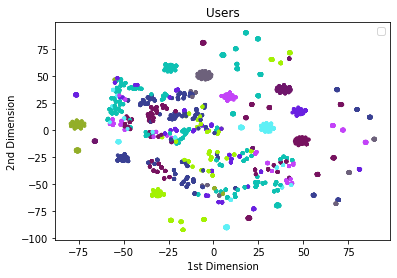

In [9]:
# Visualizing dataset
class_color = ['#77125f', '#92ae28', '#6f166b', '#5ef0f6', '#6d617b', '#a3f103', '#6920e1', '#394093', '#c343f8', '#0ec1b3']
colors = [class_color[u] for u in users_data["main_category"]]

plt.scatter(users_reduced[:,0], users_reduced[:,1], marker='.', color=colors)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')
plt.title("Users")
plt.show()

#### Construct recommender

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD



2022-05-30 13:06:22.943626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 13:06:22.943713: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [13]:
class NeuMF:

    def __init__(self, user_num, item_num):
        """
            Neural Matrix Factorization is a neural network with the following architecture:
            
            |=========================================|
            |  Legend:                                |
            |  - Generic Matrix Factorization (GMF)   |
            |  - Multilayer Perceptron (MLP)          |
            |=========================================|
            
            
            [[GMF]      [MLP]]
            [   [Dense L]    ]
            [     [Result]   ]
        """
        latent_features = 8

        # Input
        user = Input(shape=(1,), dtype='int32')
        item = Input(shape=(1,), dtype='int32')

        # User embedding for GMF
        gmf_user_embedding = Embedding(user_num, latent_features, input_length=user.shape[1])(user)
        gmf_user_embedding = Flatten()(gmf_user_embedding)

        # Item embedding for GMF
        gmf_item_embedding = Embedding(item_num, latent_features, input_length=item.shape[1])(item)
        gmf_item_embedding = Flatten()(gmf_item_embedding)

        # User embedding for MLP
        mlp_user_embedding = Embedding(user_num, 32, input_length=user.shape[1])(user)
        mlp_user_embedding = Flatten()(mlp_user_embedding)

        # Item embedding for MLP
        mlp_item_embedding = Embedding(item_num, 32, input_length=item.shape[1])(item)
        mlp_item_embedding = Flatten()(mlp_item_embedding)

        # GMF layers
        gmf_mul =  Multiply()([gmf_user_embedding, gmf_item_embedding])

        # MLP layers
        mlp_concat = Concatenate()([mlp_user_embedding, mlp_item_embedding])
        mlp_dropout = Dropout(0.2)(mlp_concat)

        # Layer1
        mlp_layer_1 = Dense(units=64, activation='relu', name='mlp_layer1')(mlp_dropout)  # (64,1)
        mlp_dropout1 = Dropout(rate=0.2, name='dropout1')(mlp_layer_1)                    # (64,1)
        mlp_batch_norm1 = BatchNormalization(name='batch_norm1')(mlp_dropout1)            # (64,1)

        # Layer2
        mlp_layer_2 = Dense(units=32, activation='relu', name='mlp_layer2')(mlp_batch_norm1)  # (32,1)
        mlp_dropout2 = Dropout(rate=0.2, name='dropout2')(mlp_layer_2)                        # (32,1)
        mlp_batch_norm2 = BatchNormalization(name='batch_norm2')(mlp_dropout2)                # (32,1)

        # Layer3
        mlp_layer_3 = Dense(units=16, activation='relu', name='mlp_layer3')(mlp_batch_norm2)  # (16,1)

        # Layer4
        mlp_layer_4 = Dense(units=8, activation='relu', name='mlp_layer4')(mlp_layer_3)       # (8,1)

        # merge GMF + MLP
        merged_vector = tf.keras.layers.concatenate([gmf_mul, mlp_layer_4])

        # Output layer
        output_layer = Dense(1, kernel_initializer='lecun_uniform', name='output_layer')(merged_vector) # 1,1 / h(8,1)

        # Model
        self.model = Model([user, item], output_layer)
        self.model.compile(optimizer= 'adam', loss= 'binary_crossentropy')

    def get_model(self):
        model = self.model
        return model


In [14]:
users = X_train[["user_id", "main_category"] + [f"{i}" for i in range(10)]]
user_size = len(users["user_id"].unique())
roars = X_train[["roar_id", "category", "roar_text"]]
roar_size = len(roars["roar_id"].unique())

In [15]:
nmf = NeuMF(user_size, roar_size)

2022-05-30 13:07:08.232214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-30 13:07:08.232315: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 13:07:08.232390: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (atp-ariel): /proc/driver/nvidia/version does not exist
2022-05-30 13:07:08.238875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model = nmf.get_model()

In [14]:
model.compile(loss="mse", optimizer=SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

2022-05-30 12:41:12.765363: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24830192 exceeds 10% of free system memory.


Error: Canceled future for execute_request message before replies were done